# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is a classification problem. We are seeking to predict labels for students as either "at risk" for failing or "not at risk" i.e. "will graduate" and not to predict a numerical value.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features (Number of Columns minus the one for target values ("passed"))
n_features = student_data.shape[1]-1

# TODO: Calculate passing students
n_passed = student_data[student_data['passed']=='yes'].shape[0]

# TODO: Calculate failing students
n_failed = student_data[student_data['passed']=='no'].shape[0]

# TODO: Calculate graduation rate (multiply denominator by 1.0 to ensure float division not integer division)
grad_rate = n_passed/(1.0*n_students)*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points (set directly with value)
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

test_size_perc = num_test/(1.0*n_students)

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify = y_all, test_size=test_size_perc, random_state=0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

## Question 2 - Model Application
List three supervised learning models that are appropriate for this problem. For each model chosen
- Describe one real-world application in industry where the model can be applied. (You may need to do a small bit of research for this — give references!)
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer:**

**Ensemble Methods (Bagging, AdaaBoost, Random Forest, Gradient Boosting)**
- Ensemble Methods were used by the BellKor team to win the Netflix Prize, which was offered if a model could increase the prediction performance of user ratings for films based on previous ratings by 10%. The team used a Gradient Boosted Decision Tree to blend over 500 individual models of differing types.
- Ensemble Methods use a collection of "weak learning" models like decision trees in combination. Used individually decision trees grown deep tend to overfit, but used in combination as a Ensemble Method averaging these weak learners can correct for that tendency. Random Forests tend to have fast runtimes and they do well with complex models with many features while maintaining predictive preformance when irrelevant or missing features are included in the training set.
- Ensemble Methods overfit predictions particularly when the data sets are very noisy. If used for regression, the model cannot predict values that are beyond the range of the training data which artificially limits the predictions. They are less useful with less complex data sets i.e. those with few features.
- This problem has many labels so using an Ensemble Method should be able to manage the complexity of the data set without much loss in predictive performance.
- Sources: 

http://www.wired.com/2009/09/how-the-netflix-prize-was-won/
http://blog.echen.me/2011/10/24/winning-the-netflix-prize-a-summary/
https://citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics/


**K-Nearest Neighbors (KNeighbors)**
- The most interesting real world example I found was an analysis of Kris Bryant's peformance in the minor leagues. The author wanted to compare his stats to all others in the Pacific Coast League from 1960-2014 to see if the "nearest neighbors" for stats in that context aligned with players that made it to the majors to see if the perfomance can be projected into that level of competition. 
- KNN is on the simpler end of the spectrum of Machine Learning algorithms and can be used for either regression or classification. It is a "lazy learner" which means the learning function is appoximated locally and computation is deferred until the prediction query. This means "training" (though training is not explicit) time is minimal which can be a benefit (compared to training time needed for other algorithms). KNN performs well with limited dimensions and size of input data.
- Becasue KNN is lazy, it also has related shortcomings. Restricting the learning function to local data means that learning is highly sensitive to the local structure of the data and that the computation of the prediction can take longer. With large input data sets or those with high dimensionality, feature extraction and/or dimension reduction are typically used as a preprocessing step to minimize the curse of dimensionality. This detracts from the simplicity of setting up a KNN model. Furthermore, KNN doesn't know which of the features are more or less important and that relative importance can be skewed by a feature with a larger scaling because it relies on a calculated vector distance to define the neighborhood. This means the weights and number of neighbors included needs to be tuned.
- KNN for this problem could be a good place to start because of the simplicity of setting up the model; however, getting good prediciton would most likely require selecting only a limited number features to include in the input data. My assumption is also that a pattern can be found from the students who failed that requires less than 10 parameters (that there will likely be a few key factors that can be correllated to failing like having a full time job).
- Sources:

https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
http://www.beyondtheboxscore.com/2015/4/21/8460365/kris-bryant-similar-players-katoh-k-nearest-neighbors

**Support Vector Machines (SVM)**
- SVMs were used to develop a model that could predict if a Twitter user was Tweeting while drinking. The team layered three SVM classifiers that used the words in the Tweets as weighted labels for the prediction.
- Because SVMs are binary linear classifiers, they do well in predicting a classification with one of two possible labels, while minimizing the classification error AND maximizing the geometric margin between the labels. This binary quality i.e. "two-class tasks" means they are relatively simple to conceptualize (and visualize graphically). They do well with high dimensional data sets.
- For multi-class tasks where there are more than two labels, SVMs need to be combined with other methods or simplified into binary problems. SVMs also require full labeling of the input data so all data has to be preprocessed/wrangled before inputting to the model. The selection of the kernel and definition of its parameters plays a big part in how effective the predictions are when the classification is non-linear which could require tuning. Also, SVMs do not perform well when the data doesn't have a clear margin for the binary prediction, when the data is noisy, or when the dataset is large.  Our prediction results are also limited to the labels (and not the probability of the labels) directly so we do not have a measure of confidence in the prediction out of the box.
- Since our problem is binary (will the student fail or pass) and our data set has a high dimension, SVMs are a good option to consider; however, it will come with a prerequisite preprocessing of the data to ensure all items are labeled and labeled with numerical data. 
- Sources:

https://en.wikipedia.org/wiki/Support_vector_machine
https://www.analyticsvidhya.com/blog/2015/10/understaing-support-vector-machine-example-code/
http://www.cbsnews.com/news/algorithm-can-tell-if-youre-drunk-tweeting/
http://arxiv.org/pdf/1603.03181v1.pdf



### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [7]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# TODO: Initialize the three models (adding them to a list)
clfs = []
clfs.append(RandomForestClassifier(random_state=17))
clfs.append(KNeighborsClassifier())
clfs.append(svm.SVC(random_state=17))

# TODO: Set up the training set sizes
# TODO: Execute the 'train_predict' function for each classifier and each training set size
# (simplified to loop through each classifier in the list)
# Loop through each classifier model type, then through the training action
for clf in clfs:
    print "\n{}: \n".format(clf.__class__.__name__)
    for n in [100, 200, 300]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)  


RandomForestClassifier: 

Training a RandomForestClassifier using a training set size of 100. . .
Trained model in 0.0130 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.9846.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7419.
Training a RandomForestClassifier using a training set size of 200. . .
Trained model in 0.0450 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7481.
Training a RandomForestClassifier using a training set size of 300. . .
Trained model in 0.0140 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7259.

KNeighborsClassifier: 

Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8592.
Made predictions in 0.0010 seconds.
F1 score for 

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - RandomForestClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0160                      | 0.0000                        | 0.9922                 | 0.7188                 |
| 200               | 0.0140          | 0.0000                       | 0.9963                 | 0.7656                 |
| 300               | 0.0140                         | 0.0010                       | 0.9951                  |    0.7970      |

** Classifer 2 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0000                        | 0.0010                        | 0.7972                 | 0.7068                |
| 200               |     0.0000              |  0.0040                       |   0.8571               | 0.7121                | 
| 300               | 0.0010                         | 0.0050                        | 0.8722                 |     0.7482     |

** Classifer 3 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0010                         | 0.0000                        |0.8591                  |0.7838                 |
| 200               | 0.0030                          | 0.0010                        |0.8693                |0.7755                 |
| 300               | 0.0050                         | 0.0020                        |0.8692                  |0.7586                 |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

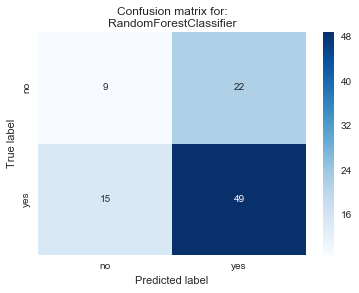

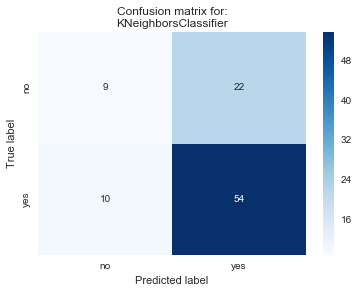

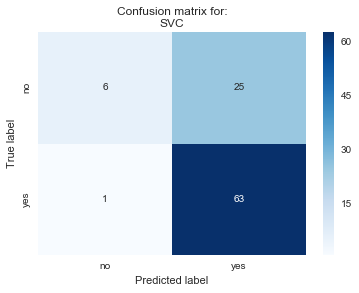

In [8]:
# Compare models predictions 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Compute confusion matrix for each model
for clf in clfs:
    cm = confusion_matrix(y_test.values, clf.predict(X_test))

    # view with a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(clf.__class__.__name__))
    plt.figure()

**Answer: **
The Random Forest Classifier Model has the best overall F1 test on the test data and also looks to be improving as the training set size increases, so if the model is in place and we continue to add data to it the F1 score may continue to improve over time. The training time for the Random Forest is on the high end for these three models, but does not appear to be all that significant of a consideration because the times are still small. Comparing the Confusion Matrices above, the Random Forest Classifier has the highest total True Positives and True Negatives combined. Total True Negatives are only outscored by SVC by 2 but SVC has man more False Positives.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

Our predicting model for whether a student passes or fails takes in thirty characteristics, such as study time per week, travel time to and from school, and whether or not they have access to the internet from a large sample of students. We supply our model with a portion of the data to train it to make good predictions. We found that using a "Random Forest" technique works well for our problem - in this category of models, we "grow" a collection of "trees" that each reviews each characteristic and "funnels" the corresponding students incrementally into groups based on a sequence of conditions. We can think of the trees as similar to a list of directions where we continue left or right at each juncture based on if we fit that condition such as "if I have internet access at home" - if yes, go left, if no, go right and proceed to the next question. Each of our students is passed through this sequence giving us groups of students that we can review how well that group correctly identifies those who pass or fail.  We can then input new samples of students to test how well the model has been trained to predict a passing or failing student. Each of our our trees may have some error in grouping the students with the wrong label, but as a collection the trees overall predictive error is minimized. Our model with its current training is 80.5% accurate in its predictions.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [18]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {'max_depth': range(1, 11), 'n_estimators': range(3,11), 'max_features': range(3,16) }

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state=17)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer, verbose=0)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0010 seconds.
Tuned model has a training F1 score of 0.8788.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.8056.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **
The original F1 score for the untuned model with 300 training points was 0.7970.
Tuned model has a training F1 score of 0.8788.
Tuned model has a testing F1 score of 0.8056.
This gives us a 1% improvement.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.